In [194]:
import torch
from youtube import YoutubeDataset
import matplotlib.pyplot as plt
from Loader_17 import normalize
import torch.nn.functional as F
from einops import rearrange, repeat
import torch.nn as nn
from deform_video import (
    DAVIS_withPoint,
    IMGPositionEmbeddingSine,
    PositionalEncoding,
    get_valid_ratio,
    MLP,
)
from deform_model import get_batch_average_bou_iou
import gc

In [3]:
point_num = 16
frame_num = 6

In [6]:
train_dataset = YoutubeDataset(
    is_train=True,
    point_num=point_num,
    frame_num=frame_num,
    is_eval=False,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=8,
)

In [17]:
imgs, masks, points = next(iter(train_loader))
imgs.shape, masks.shape, points.shape

(torch.Size([1, 6, 3, 224, 224]),
 torch.Size([1, 6, 224, 224]),
 torch.Size([1, 6, 16, 2]))

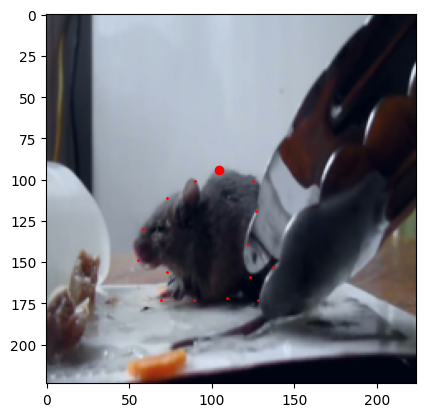

In [29]:
tmp_img = normalize(imgs[0, 0]).numpy().transpose(1, 2, 0)
point_idx = 0
tmp_point = points[0, 0, point_idx].numpy()
tmp_points = points[0, 0].numpy()
plt.imshow(tmp_img)
plt.scatter(tmp_point[0], tmp_point[1], c='r')
plt.plot(tmp_points[:, 0], tmp_points[:, 1], 'ro', markersize=1)

torch.Size([1, 6, 16, 48841, 2])


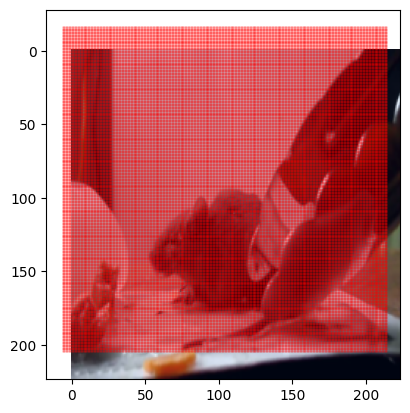

In [108]:
def get_neighbor_points(points: torch.Tensor, deviation: int) -> torch.Tensor:
    """
    points: (B, T, N, 2)
    deviation: int
    return: (B, T, N, (deviation*2+1)^2, 2)
    """
    B, T, N, _ = points.shape
    neighbor_points = torch.zeros(B, T, N, (deviation * 2 + 1) ** 2, 2)
    for i in range(-deviation, deviation + 1):
        for j in range(-deviation, deviation + 1):
            neighbor_points[
                :, :, :, (i + deviation) * (2 * deviation + 1) + j + deviation
            ] = points + torch.tensor([j, i], dtype=torch.float32)
    return neighbor_points


# write a more efficient version of get_neighbor_points
def get_neighbor_points(points: torch.Tensor, deviation: int) -> torch.Tensor:
    """
    points: (B, T, N, 2)
    deviation: int
    return: (B, T, N, (deviation*2+1)^2, 2)
    """
    B, T, N, _ = points.shape
    offsets = torch.stack(
        torch.meshgrid(
            torch.arange(-deviation, deviation + 1),
            torch.arange(-deviation, deviation + 1),
            indexing="xy",
        ),
        dim=-1,
    )
    offsets = rearrange(offsets, "x y k -> (x y) k")
    neighbor_points = points.unsqueeze(3) + offsets.view(1, 1, 1, -1, 2).to(
        points.device
    )
    return neighbor_points




deviation = 110
neighbor_points = get_neighbor_points(points, deviation)
print(neighbor_points.shape)
plt.imshow(tmp_img)
tmp_points = neighbor_points[0, 0, point_idx].numpy()
plt.plot(tmp_points[:, 0], tmp_points[:, 1], "ro", markersize=1, alpha=0.2)

In [109]:
imgs.shape

torch.Size([1, 6, 3, 224, 224])

torch.Size([1, 6, 16, 48841, 2])
torch.Size([1, 16, 48841, 2])
torch.Size([1, 3, 16, 48841])
torch.Size([3, 48841])
221
torch.Size([3, 221, 221])


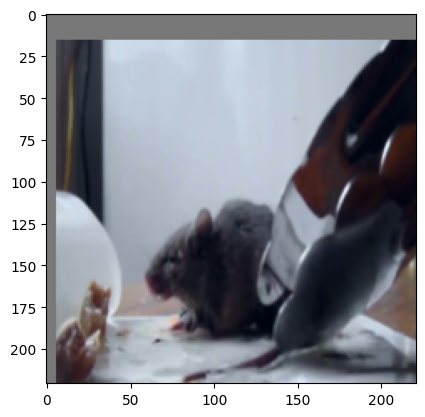

In [110]:
support_points = (neighbor_points / 224 - 0.5) * 2
print(support_points.shape)
tmp_points = support_points[:, 0, :]
print(tmp_points.shape)
feats = F.grid_sample(imgs[:,0], tmp_points, align_corners=True, padding_mode="zeros")
print(feats.shape)
tmp_feat = normalize(feats[0, :, point_idx])
print(tmp_feat.shape)
tmp_size = int((2 * deviation + 1) )
print(tmp_size)
tmp_feat = rearrange(tmp_feat, 'c (h w) -> c h w', h=tmp_size)
print(tmp_feat.shape)
tmp_feat = tmp_feat.permute(1, 2, 0).numpy()

plt.imshow(tmp_feat)

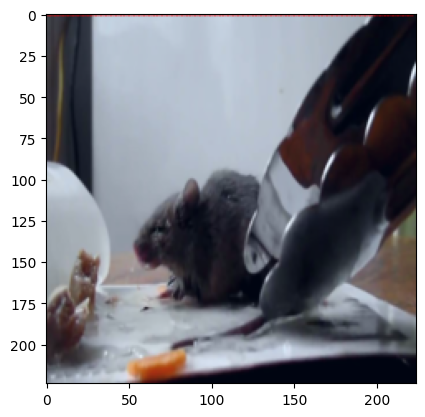

In [201]:
# use the meshgrid to get points of the whole image
all_points = torch.stack(
    torch.meshgrid(
        torch.arange(224), torch.arange(224), indexing="xy"
    ),
    dim=-1,
)
all_points = rearrange(all_points, "x y k -> (x y) k")
plt.imshow(tmp_img)
plt.scatter(all_points[:222, 0], all_points[:222, 1], c='r', s=1, alpha=0.2)

In [111]:
neighbor_points.shape

torch.Size([1, 6, 16, 48841, 2])

In [ ]:
imgs.shape, points.shape

(torch.Size([1, 6, 3, 224, 224]), torch.Size([1, 6, 16, 2]))

: 

torch.Size([1, 6, 3, 16, 121])


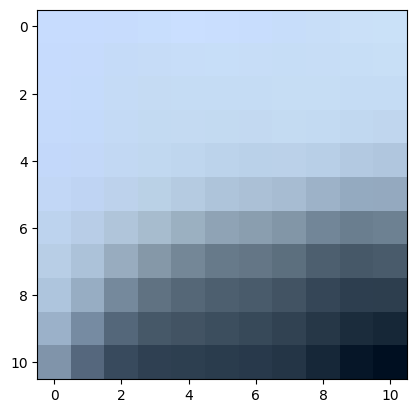

In [120]:
def get_point_feats(
    imgs: torch.Tensor,
    points: torch.Tensor,
    deviation: int,
) -> torch.Tensor:
    B, T, N, _ = points.shape
    neighbor_points = get_neighbor_points(points, deviation)
    support_points = (neighbor_points / 224 - 0.5) * 2
    imgs = rearrange(imgs, "B T C H W -> (B T) C H W")
    support_points = rearrange(support_points, "B T N K C -> (B T) N K C")
    feats = F.grid_sample(
        imgs, support_points, align_corners=True, padding_mode="zeros"
    )
    feats = rearrange(feats, "(B T) N K C -> B T N K C", B=B, T=T)
    return feats

deviation = 5
point_feats = get_point_feats(imgs, points, deviation)
print(point_feats.shape)
tmp_point_feats = point_feats[0, 0, :, point_idx]
tmp_point_feats = rearrange(tmp_point_feats, 'c (h w) -> c h w', h=deviation*2+1)
tmp_point_feats = tmp_point_feats.permute(1, 2, 0).numpy()
tmp_point_feats = normalize(tmp_point_feats)
plt.imshow(tmp_point_feats)

In [125]:
torch.cuda.set_device(3)

In [127]:
imgs.shape, masks.shape, points.shape

(torch.Size([1, 6, 3, 224, 224]),
 torch.Size([1, 6, 224, 224]),
 torch.Size([1, 6, 16, 2]))

In [181]:
class CotrackerLightNew(nn.Module):
    def __init__(
        self,
        point_num: int,
        deviation: int = 2,
        refine_iter: int = 1,
        freeze_featup: bool = True,
        d_model: int = 128,
        n_heads: int = 8,
        d_ffn: int = 512,
        n_layers: int = 1,
        offset_ratio: float = 1.0,
    ):
        super().__init__()
        self.refine_iter = refine_iter
        self.deviation = deviation
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        )
        if freeze_featup:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_featup = 384
        if d_featup != d_model:
            self.featup_fc = nn.Linear(d_featup, d_model)
        else:
            self.featup_fc = nn.Identity()
        self.medium_level_size = [14, 28, 56, 112]
        n_levels = len(self.medium_level_size) + 1
        self.offset_ratio = offset_ratio
        self.pos_2d = IMGPositionEmbeddingSine(d_model)
        self.pos_1d = PositionalEncoding(d_model)
        self.level_pos = nn.Embedding(n_levels, d_model)
        nn.init.xavier_uniform_(self.level_pos.weight)
        point_feat_dim = d_model * n_levels * (self.deviation * 2 + 1) ** 2
        self.point_mlp = MLP(
            point_feat_dim,
            point_feat_dim,
            d_model,
            3,
        )
        self.fir_layernorm = nn.LayerNorm(d_model)
        self.fir_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model,
                n_heads,
                d_ffn,
                batch_first=True,
            ),
            num_layers=n_layers,
        )
        self.other_layernorm = nn.LayerNorm(d_model)
        self.other_decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(
                d_model,
                n_heads,
                d_ffn,
                batch_first=True,
            ),
            num_layers=n_layers,
        )
        self.delta_xy_fc = MLP(d_model, d_model, 2, 2)


    def forward(self, imgs: torch.Tensor, points: torch.Tensor):
        B, T, N, _ = points.shape
        B, T, C, H, W = imgs.shape
        imgs = rearrange(imgs, "B T C H W -> (B T) C H W")
        feats = self.featup(imgs)
        feats = rearrange(feats, "B C H W -> B (H W) C")
        feats = self.featup_fc(feats)
        feats = rearrange(feats, "B (H W) C -> B C H W", H=H, W=W)
        # feats = rearrange(feats, "(B T) C H W -> B T C H W", B=B, T=T)
        diff_feats = []
        for low_res in self.medium_level_size:
            diff_feats.append(
                F.interpolate(
                    feats,
                    size=(low_res, low_res),
                    mode="bilinear",
                )
            )
        diff_feats.append(feats)
        for i, diff_feat in enumerate(diff_feats):
            padding_mask = torch.zeros_like(diff_feat[:, 0, :, :]).bool()
            diff_feats[i] += self.pos_2d(diff_feat, padding_mask)
            diff_feats[i] += repeat(
                self.level_pos.weight[i],
                "d -> (B T) d H W",
                B=B,
                T=T,
                H=diff_feat.shape[2],
                W=diff_feat.shape[3],
            )
            diff_feats[i] = rearrange(
                diff_feats[i], "(B T) C H W -> B T C H W", B=B, T=T
            )
        diff_point_feats = []
        for diff_feat in diff_feats:
            diff_point_feats.append(
                get_point_feats(
                    diff_feat,
                    points,
                    self.deviation,
                )
            )
        point_feats = torch.cat(diff_point_feats, dim=-1)
        point_feats = rearrange(point_feats, "B T C N K -> B T N (C K)")
        point_feats = rearrange(point_feats, "B T N C -> (B T) N C")
        point_feats = self.point_mlp(point_feats)
        point_feats = rearrange(point_feats, "(B T) N C -> B T N C", B=B, T=T)
        fir_point_feats = point_feats[:, 0]
        fir_point_feats = self.fir_layernorm(fir_point_feats)
        fir_point_feats = self.pos_1d(fir_point_feats)
        fir_memory = self.fir_encoder(fir_point_feats)
        
        other_point_feats = point_feats[:, 1:]
        other_point_feats = rearrange(other_point_feats, "B T N C -> B (T N) C")
        other_point_feats = self.other_layernorm(other_point_feats)
        other_point_feats = self.pos_1d(other_point_feats)
        other_point_feats = self.other_decoder(
            tgt=other_point_feats,
            memory=fir_memory,
        )
        delta_xy = self.delta_xy_fc(other_point_feats)
        delta_xy = (delta_xy.sigmoid() - 0.5) * self.offset_ratio
        other_points = points[:, 1:]
        other_points = rearrange(other_points, "B T N C -> B (T N) C")
        other_points = other_points + delta_xy * 224
        result = rearrange(other_points, "B (T N) C -> B T N C", B=B, T=T - 1)
        output_coords = []
        output_coords.append(result)
        output_coords = torch.stack(output_coords, dim=1)
        return output_coords
        


model = CotrackerLightNew(point_num).cuda()
model(imgs.cuda(), points.cuda()).shape

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 1, 5, 16, 2])

In [ ]:
model(imgs.cuda(), points.cuda()).shape

torch.Size([1, 6, 16, 128])
torch.Size([1, 5, 16, 128])
torch.Size([5, 16, 128])


In [187]:
from polygon import SoftPolygon, RasLoss
from Loader_17 import DAVIS_Rawset
from deform_video import DAVIS_withPoint
from cotracker import DAVIS_Video, CoEvaler, VideoLoss
from torch.utils.data import DataLoader
from torch.optim import Adam

In [186]:
val_raw_set = DAVIS_Rawset(is_train=False)
val_point_set = DAVIS_withPoint(val_raw_set, point_num, is_train=False)
val_video_set = DAVIS_Video(val_point_set.raw_data_set, frame_num)
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
coevaler = CoEvaler(val_point_set.raw_data_set, gt_rasterizer)

In [188]:
optimizer = Adam(model.parameters(), lr=1e-4)
ras_loss = RasLoss().cuda()
video_loss = VideoLoss(ras_loss, gt_rasterizer).cuda()

In [189]:
video_idx = 6
val_video_set = DAVIS_Video(val_point_set.raw_data_set, frame_num, [video_idx], is_eval=False, use_fir_point=True)
val_video_loader = DataLoader(val_video_set, batch_size=1, shuffle=False)

In [190]:
loss_dict = {}
iou_dict = {}
epoch_num = 200

In [191]:
for e in range(epoch_num):
    total_loss = 0
    total_iou = 0
    for total_imgs, total_masks, total_points in val_video_loader:
        optimizer.zero_grad()
        pred_points = model(total_imgs.cuda(), total_points.cuda())
        target_masks = total_masks[:, 1:]
        loss, iou = video_loss(pred_points, target_masks.cuda())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()
    loss_dict[e] = total_loss / len(val_video_loader)
    iou_dict[e] = total_iou / len(val_video_loader)
    print(f"Epoch {e}, Loss: {loss_dict[e]:.4f}, IoU: {iou_dict[e]:.4f}")

Epoch 0, Loss: 0.4536, IoU: 0.3765
Epoch 1, Loss: 0.6857, IoU: 0.1882
Epoch 2, Loss: 0.4855, IoU: 0.3457
Epoch 3, Loss: 0.4327, IoU: 0.3925
Epoch 4, Loss: 0.3541, IoU: 0.4723
Epoch 5, Loss: 0.3727, IoU: 0.4540
Epoch 6, Loss: 0.3196, IoU: 0.5152
Epoch 7, Loss: 0.3729, IoU: 0.4553
Epoch 8, Loss: 0.3338, IoU: 0.4974
Epoch 9, Loss: 0.3845, IoU: 0.4414
Epoch 10, Loss: 0.3775, IoU: 0.4479
Epoch 11, Loss: 0.2929, IoU: 0.5412
Epoch 12, Loss: 0.3534, IoU: 0.4757
Epoch 13, Loss: 0.3414, IoU: 0.4870
Epoch 14, Loss: 0.3117, IoU: 0.5180
Epoch 15, Loss: 0.3460, IoU: 0.4800
Epoch 16, Loss: 0.3306, IoU: 0.4992
Epoch 17, Loss: 0.3370, IoU: 0.4906
Epoch 18, Loss: 0.3237, IoU: 0.5039
Epoch 19, Loss: 0.2980, IoU: 0.5353
Epoch 20, Loss: 0.3102, IoU: 0.5189
Epoch 21, Loss: 0.2710, IoU: 0.5679
Epoch 22, Loss: 0.2733, IoU: 0.5636
Epoch 23, Loss: 0.3271, IoU: 0.5031
Epoch 24, Loss: 0.3185, IoU: 0.5113
Epoch 25, Loss: 0.3215, IoU: 0.5095
Epoch 26, Loss: 0.2746, IoU: 0.5609
Epoch 27, Loss: 0.2995, IoU: 0.5331
Ep

In [192]:
coevaler = CoEvaler(val_point_set.raw_data_set, gt_rasterizer, frame_num=frame_num)

In [193]:
iou, total_pred_points = coevaler.eval_one_video(video_idx, model)
iou

tensor(0.7000, device='cuda:3')

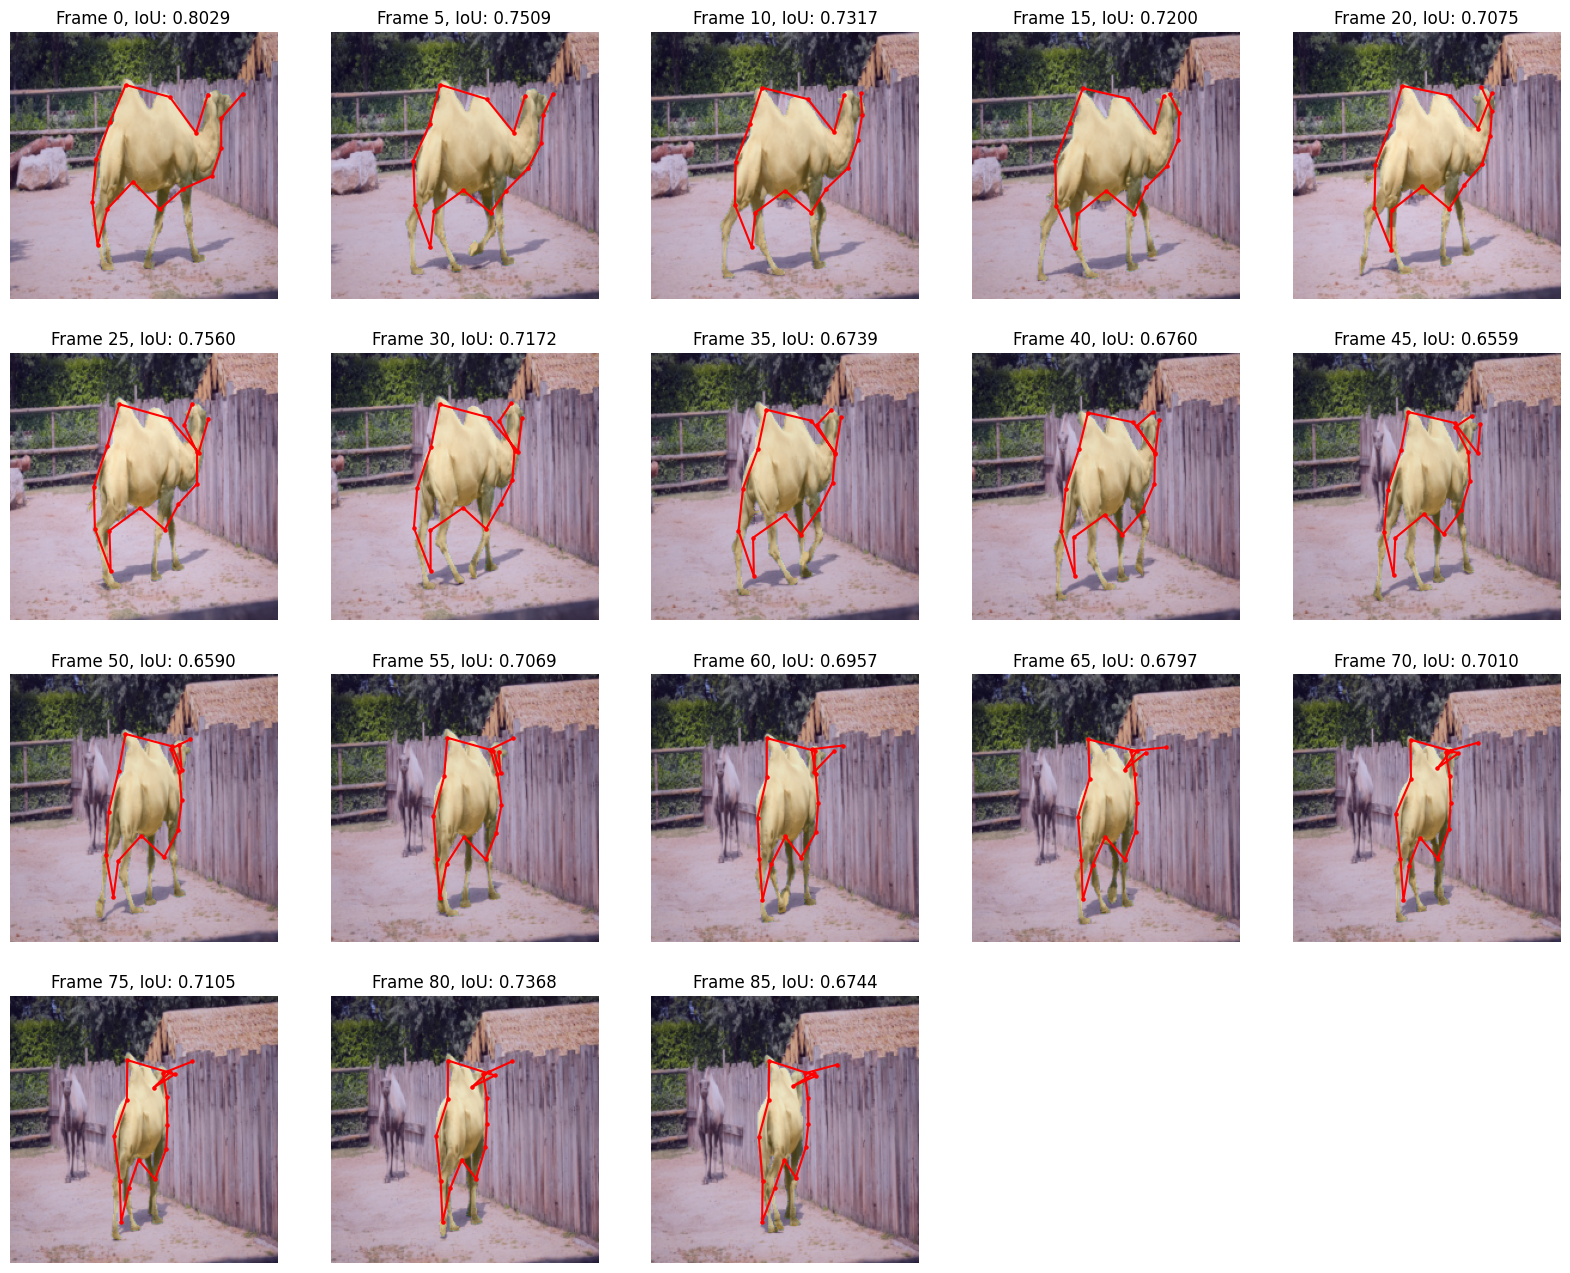

In [195]:
img_per_line = 5
mask_alpha = 0.2
only_show_every = 5
video_data = coevaler.raw_set[video_idx]
frame_num = len(video_data) // only_show_every
line_num = frame_num // img_per_line + 1
plt.figure(figsize=(20, 4 * line_num))
# for i, pred_point in enumerate(total_pred_points):
#     plt.subplot(line_num, img_per_line, i + 1)
#     plt.axis("off")
#     i = i * only_show_every
#     img, mask, point = video_data[i]
#     plt.imshow(normalize(img).permute(1, 2, 0))
#     iou = get_batch_average_bou_iou(pred_point.unsqueeze(0).cuda(), mask.unsqueeze(0).cuda(), gt_rasterizer).item()
#     plt.title(f"IoU: {iou:.4f}")
#     plt.scatter(pred_point[:, 0], pred_point[:, 1], c="r", s=5)
#     plt.plot(pred_point[:, 0], pred_point[:, 1], c="r")
#     plt.imshow(mask, alpha=mask_alpha)

for i in range(frame_num):
    plt.subplot(line_num, img_per_line, i + 1)
    plt.axis("off")
    i = i * only_show_every
    img, mask, point = video_data[i]
    pred_point = total_pred_points[i]
    plt.imshow(normalize(img).permute(1, 2, 0))
    iou = get_batch_average_bou_iou(pred_point.unsqueeze(0).cuda(), mask.unsqueeze(0).cuda(), gt_rasterizer).item()
    plt.title(f"Frame {i}, IoU: {iou:.4f}")
    plt.scatter(pred_point[:, 0], pred_point[:, 1], c="r", s=5)
    plt.plot(pred_point[:, 0], pred_point[:, 1], c="r")
    plt.imshow(mask, alpha=mask_alpha)

In [183]:
gc.collect()
torch.cuda.empty_cache()